# MEMERAG

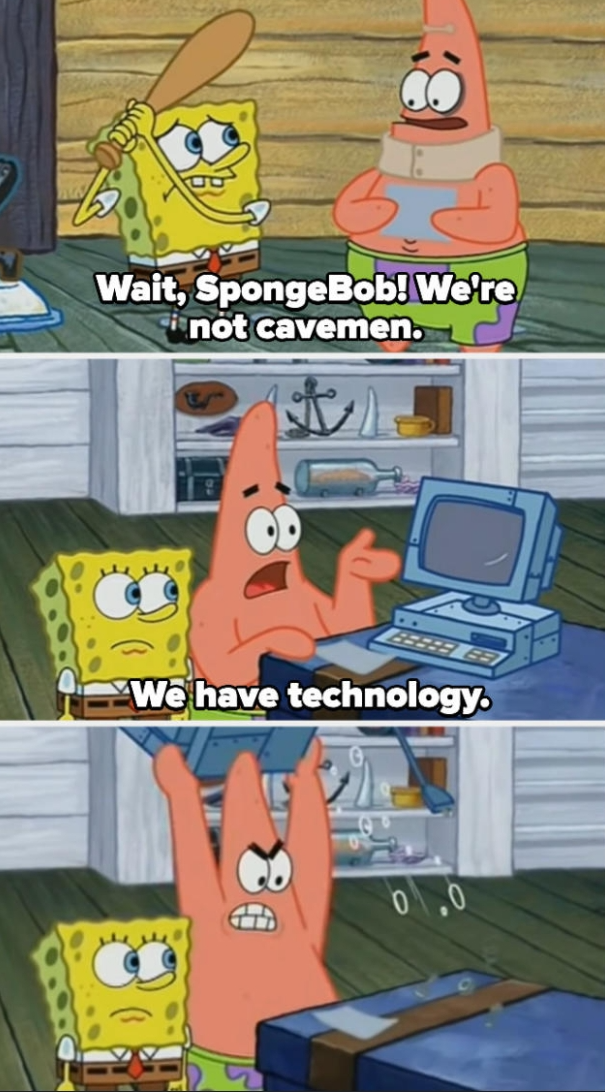

# ARCHITECTURE

In [ ]:
📁 meme_rag/
├── 📁 meme_fns/          # 👈 Utility scripts
│   ├── memes_list.py
│   ├── emotion_utils.py
│   └── (optional: meme_loader.py)
├── 📁 meme_config/       # 🔒 Private configs like keys
│   └── openai_key.txt
├── 📁 memes/             # 📷 Your meme images / gifs
├── bot_runner.ipynb      # 🚀 Your main Colab notebook
├── README.md             # (optional, for project description)


# BASIC RUN

In [ ]:
!pip install langchain
!pip install chromadb
!pip install sentence-transformers
!pip install faiss-cpu
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.1 MB/s eta 0:00:0

In [ ]:
pip install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.3/661.3 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.76.0
    Uninstalling openai-1.76.0:
      Successfully uninstalled openai-1.76.0


### 0. LOAD CONTENT & IMPORTS

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load key manually from plain .txt
with open('/content/drive/MyDrive/meme_rag/meme_config/openai_key.txt', 'r') as f:
    openai_key = f.read().strip()

print("✅ Key Loaded:", openai_key.startswith("sk-"))


✅ Key Loaded: True


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/meme_rag')

In [ ]:
# Local Path
import shutil
import os

MEME_FOLDER_DRIVE = '/content/drive/MyDrive/meme_rag/memes' # Your Drive path
MEME_FOLDER_LOCAL = '/content/memes_local' # Local Colab path


In [ ]:
from memes_list import meme_examples

In [ ]:
# === 1. Imports ===
# (Later import actual libraries: langchain, chroma, faiss, huggingface, etc.)

import os, shutil, random
import numpy as np
import pandas as pd
import openai
import faiss
from sentence_transformers import SentenceTransformer
from IPython.display import HTML, Image, display
from openai import OpenAI
from datetime import datetime
import time



In [ ]:
# === 1. Embedder ===
class Embedder:
    def __init__(self):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
    def embed(self, text: str) -> np.ndarray:
        return self.model.encode([text])[0]


In [ ]:
# === 2. Retriever ===
class Retriever:
    def __init__(self, dim=384):
        self.index = faiss.IndexFlatL2(dim)
        # Store memes with their original index IDs for easy lookup
        self.memes_by_id = {}
        self.next_id = 0

    def add_documents(self, memes: list, embedder: Embedder):
        """
        memes: list of dict, each {'caption':..., 'image':..., 'emotion':... (optional)}
        """
        vecs = []
        ids_to_add = []
        for m in memes:
            vecs.append(embedder.embed(m['caption']))
            current_id = self.next_id
            self.memes_by_id[current_id] = m # Store meme data keyed by FAISS ID
            ids_to_add.append(current_id)
            self.next_id += 1

        if vecs:
            # Use IndexIDMap to map FAISS internal IDs to our custom IDs
            self.index = faiss.IndexIDMap(faiss.IndexFlatL2(self.index.d))
            self.index.add_with_ids(np.vstack(vecs), np.array(ids_to_add, dtype='int64'))
            print(f"✅ Indexed {len(vecs)} memes.")
        else:
            print("⚠️ No vectors to add to index.")


    def retrieve(self, query_vec: np.ndarray, top_k=10, emotion=None) -> list: # Increase initial top_k
        if self.index.ntotal == 0:
            print("⚠️ Index is empty. Cannot retrieve.")
            return []

        # 1. Search the main index for more candidates initially
        #    Increase k because filtering will remove some results.
        search_k = top_k * 5 # Or some other multiplier, adjust as needed
        search_k = min(search_k, self.index.ntotal) # Can't retrieve more than exist

        D, I = self.index.search(np.array([query_vec]), search_k)

        # Get the actual meme data using the retrieved IDs
        initial_results = [self.memes_by_id[idx] for idx in I[0] if idx != -1] # idx can be -1 if k > ntotal

        if not initial_results:
            return []

        # 2. Filter these results by emotion, if applicable
        if emotion and emotion != "neutral": # Assuming 'neutral' means no filter
            filtered_results = [
                meme for meme in initial_results
                if meme.get("emotion") == emotion
            ]
            if not filtered_results:
                print(f"⚠️ No top memes found for emotion: {emotion}. Falling back to general results.")
                # Fallback: return top_k general results instead of empty list
                return initial_results[:top_k]
            else:
                # Return the top_k emotionally relevant results
                return filtered_results[:top_k]
        else:
            # No emotion filter needed, just return the top_k overall results
            return initial_results[:top_k]

In [ ]:
# === 3. Generator ===
class MemeSelector:
    def __init__(self):
        pass
    def generate(self, query: str, context: list) -> str:
        """
        context: list of meme dicts, pick the top one.
        Returns: the filename of the meme to display.
        """
        if not context:
            return None
        return context[0]['image']


In [ ]:
# === 4. RAG Pipeline Manager ===
class MemeRAGManager:
    def __init__(self, embedder, retriever, selector):
        self.embedder = embedder
        self.retriever = retriever
        self.selector  = selector
    def run(self, user_query: str) -> str:
        qv      = self.embedder.embed(user_query)
        cands   = self.retriever.retrieve(qv)
        pick    = self.selector.generate(user_query, cands)
        return pick  # e.g. "sadge_pepe.png"

In [ ]:
# === 4.5 Smart Meme RAG Manager (Emotion Aware) ===
class SmartMemeRAGManager:
    def __init__(self, embedder, retriever, selector):
        self.embedder = embedder
        self.retriever = retriever
        self.selector = selector

    def run(self, user_query: str) -> str:
        # Step 1: Detect emotion from user message
        detected_emotion = get_emotion_from_message(user_query)
        print(f"🧠 Detected Emotion: {detected_emotion}")

        # Step 2: Embed user query
        query_vec = self.embedder.embed(user_query)

        # Step 3: Retrieve candidates matching emotion (fallback if none)
        candidates = self.retriever.retrieve(query_vec, top_k=3, emotion=detected_emotion)

        # Step 4: Pick the final meme
        final_pick = self.selector.generate(user_query, candidates)

        return final_pick


# EMOTIONAL UTILS

In [ ]:
def filter_by_emotion(memes, target_emotion):
    """
    Filter meme list by emotion.
    """
    return [m for m in memes if m.get("emotion") == target_emotion]

In [ ]:
def get_emotion_from_message(msg):
    """
    Infer emotion based on simple keyword matching.
    """
    msg = msg.lower()
    if any(word in msg for word in ["sad", "down", "depressed", "cry"]):
        return "sad"
    if any(word in msg for word in ["angry", "mad", "rage", "pissed"]):
        return "angry"
    if any(word in msg for word in ["tired", "exhausted", "sleepy"]):
        return "tired"
    if any(word in msg for word in ["hype", "excited", "fired up"]):
        return "hype"
    if any(word in msg for word in ["confused", "lost", "unsure"]):
        return "confused"
    if any(word in msg for word in ["awkward", "embarrassed"]):
        return "awkward"
    if any(word in msg for word in ["coping", "overwhelmed"]):
        return "coping"
    if any(word in msg for word in ["funny", "lol", "lmao"]):
        return "funny"
    if any(word in msg for word in ["evil", "villain", "chaos"]):
        return "evil"
    if any(word in msg for word in ["wholesome", "nice", "sweet"]):
        return "wholesome"
    return "neutral"

# CLEANER UI FOR TEXT

In [ ]:
from IPython.display import display
import ipywidgets as widgets

def get_input():
    text_box = widgets.Text(
        value='',
        placeholder='Type your message...',
        description='You:',
        disabled=False
    )
    display(text_box)

    input_done = widgets.Button(description="Submit")
    display(input_done)

    user_msg = {}

    def handle_submit(_):
        user_msg["text"] = text_box.value

    input_done.on_click(handle_submit)

    while "text" not in user_msg:
        pass  # Wait for user

    return user_msg["text"]


# MAKE CHATBOT

In [ ]:
from openai import OpenAI

class MemeAugmentedChatbot:
    def __init__(self, rag_mgr: MemeRAGManager, openai_key: str, meme_folder: str):
        self.rag = rag_mgr
        self.mf = meme_folder
        self.cooldown = 0
        self.client = OpenAI(api_key=openai_key)
        self.chat_log = []
        self.personality = "You are a friendly and witty meme expert who uses humor to lighten conversations."

    def ask_openai(self, msg: str) -> str:
        """
        Streams the model’s reply token by token using OpenAI v1+ client.
        """
        model_name = "gpt-4.1"

        print("🤔 Thinking…", end="", flush=True)

        # OpenAI v1+ streaming call
        response = self.client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": self.personality},
                {"role": "user", "content": msg}
            ],
            max_tokens=150,
            stream=False,
        )

        full_reply = response.choices[0].message.content
        print(f"\r🤖 {full_reply}")
        return full_reply

        for chunk in stream:
            token = chunk.choices[0].delta.content or ""
            print(token, end="", flush=True)
            full_reply += token

        print()  # Final newline
        return full_reply

    def should_meme(self, msg: str) -> bool:
        if self.cooldown > 0:
            self.cooldown -= 1
            return False
        keywords = ["sad", "happy", "angry", "confused", "hype", "stressed", "winning", "losing", "tired"]
        if any(w in msg.lower() for w in keywords):
            self.cooldown = 1
            return True
        if random.random() < 0.6:
            self.cooldown = 1
            return True
        return False

    def set_personality(self, new_persona: str):
        personalities = {
            "default": "You are a friendly and witty meme expert who uses humor to lighten conversations.",
            "sithlord": "You are a Sith Lord meme master who uses dark humor, sarcasm, and ruthless memes to guide the weak.",
            "hypebeast": "You are an over-the-top hype man who uses memes to boost the user's confidence to absurd levels.",
            "sadgecoach": "You are a kind, supportive meme expert who gently lifts users' spirits when they are sad.",
            "evilgenius": "You are an evil mastermind who plots memes to dominate conversations through cunning wit."
        }
        if new_persona in personalities:
            self.personality = personalities[new_persona]
            print(f"🎭 Personality switched to {new_persona}!")
        else:
            print(f"⚠️ Unknown personality '{new_persona}'. Available: {list(personalities.keys())}")

    def show_meme(self, fname: str):
        # Now consistently uses the local path passed during init
        src = os.path.join(self.mf, fname)
        if os.path.exists(src):
             # No need to copy anymore, just display from the local path
             display(Image(filename=src))
        else:
             print(f"⚠️ Meme image not found locally: {src}")

    def chat(self, user_msg: str):
        meme_filename = None

        # Handle personality switch
        if user_msg.startswith("!set personality "):
            new_persona = user_msg.split("!set personality ")[1].strip()
            self.set_personality(new_persona)
            return

        # Display input context
        print(f"\n🧠 You said: {user_msg}")

        # Ask LLM and collect full response
        reply = self.ask_openai(user_msg)

        # Visual divider
        print("\n" + "—" * 60)

        # Determine if meme should be shown
        if self.should_meme(user_msg):
            meme_filename = self.rag.run(user_msg)

            # Attempt to render
            if meme_filename and meme_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                print("\n🎭 Meme Reaction:")
                time.sleep(0.4)  # allow Colab to prepare visual
                self.show_meme(meme_filename)
            else:
                print("\n⚠️ No suitable meme found for this input.")
        else:
            print("\n😎 Chill mode — no meme this time.")

        # Log the turn
        self.chat_log.append({
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "user": user_msg,
            "bot_response": reply,
            "meme": meme_filename if meme_filename else "None"
        })

    def save_chatlog(self, filename="chatlog.csv"):
        df = pd.DataFrame(self.chat_log)
        df.to_csv(filename, index=False)
        print(f"✅ Chat log saved as {filename}")


## MAIN

🔄 Copying memes from Drive to local Colab environment...
✅ Memes copied locally in 9.20 seconds.
✅ Indexed 20 memes.
🎉 Meme-Augmented Chatbot Ready! Type 'quit' to exit.
📝 Type your message:

🧠 You said: alright baby this should work way faster now 
🤖 Oh la la, someone just upgraded their Wi-Fi from "potato" to "lightning bolt"! 🚀 I'm ready for this blazing speed—let’s hope the only thing buffering now is my sense of humor. What’s on the meme menu, speedy?

————————————————————————————————————————————————————————————
🧠 Detected Emotion: neutral

🎭 Meme Reaction:
⚠️ Meme image not found locally: /content/drive/MyDrive/meme_rag/memes/its_all_coming_together.png
📝 Type your message:

🧠 You said: nope need those memes now 
🤖 You rang? Here’s your instant meme dose. 🍕

**When you ask for memes and I show up:**
```
Me: Arrives with memes
You: Bracing for impact
Internet: THE LEVEL OF MEMES IS TOO DAMN HIGH
```

**Classic starter pack:**

1. *Distracted Boyfriend* — “You, looking at my memes 

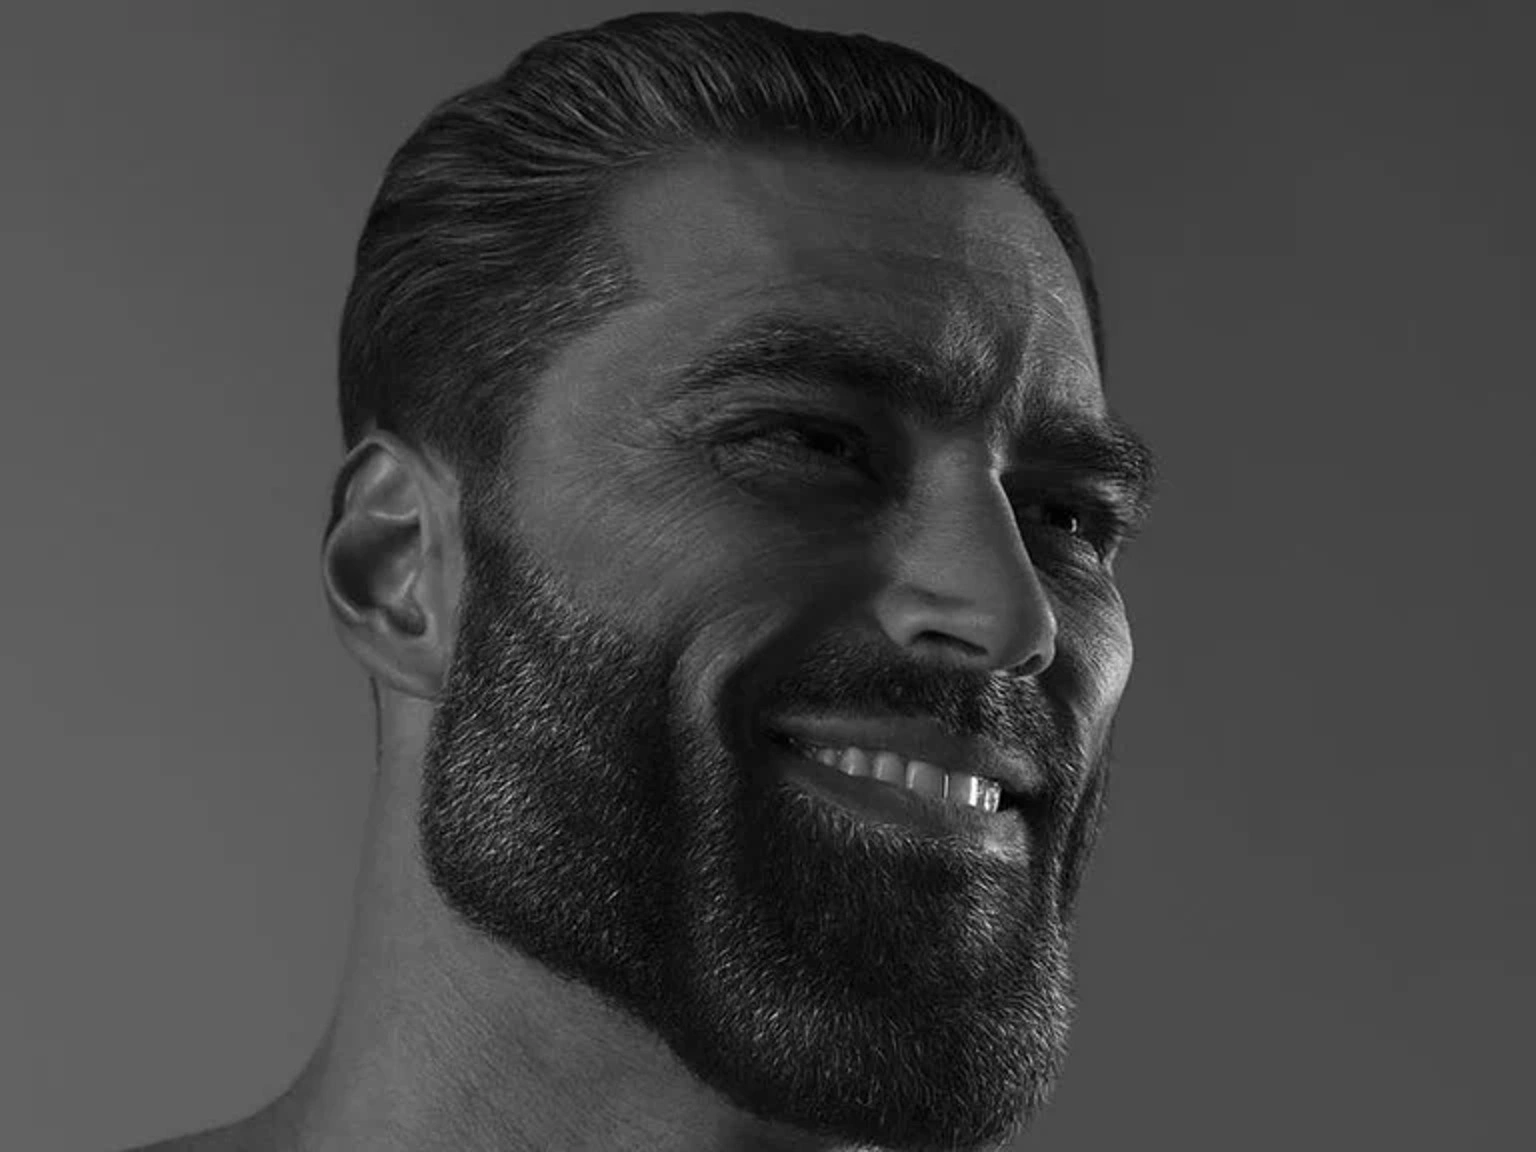

📝 Type your message:

🧠 You said: ah so it still working? 
🤖 Yep, still working—better than your motivation on a Monday morning! 😜

What can I meme-ify or help you with today?

————————————————————————————————————————————————————————————

😎 Chill mode — no meme this time.
📝 Type your message:

🧠 You said: so now the prompt box just doesn't want to show huh? 
🤖 Right?? The prompt box is out here taking a sick day while we’re all just trying to live our best digital lives. Honestly, it’s probably flirting with the text cursor on another website. 😂

But seriously, are you having trouble with the prompt/input box not appearing somewhere? I can help troubleshoot if you want—unless you think it just needs more emotional support (and maybe a good meme).

————————————————————————————————————————————————————————————

😎 Chill mode — no meme this time.
📝 Type your message:
dang haven't given me memes yet - sad

🧠 You said: dang haven't given me memes yet - sad
🤖 No memes yet? Wow, I must’ve forgo

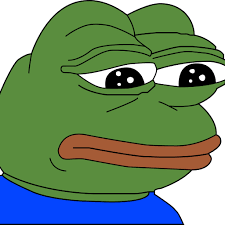

📝 Type your message:


In [ ]:
if __name__ == "__main__":
    # Optimization Block
    print("🔄 Copying memes from Drive to local Colab environment...")
    start_copy_time = time.time()
    if os.path.exists(MEME_FOLDER_LOCAL):
        shutil.rmtree(MEME_FOLDER_LOCAL) # Remove old copy if it exists
    try:
        shutil.copytree(MEME_FOLDER_DRIVE, MEME_FOLDER_LOCAL)
        end_copy_time = time.time()
        print(f"✅ Memes copied locally in {end_copy_time - start_copy_time:.2f} seconds.")
    except Exception as e:
        print(f"❌ Error copying memes: {e}")
        # Decide how to handle this - maybe exit or fall back to Drive paths
        MEME_FOLDER_LOCAL = MEME_FOLDER_DRIVE # Fallback to using Drive directly if copy fails
    # --- End Add this block ---

    # 7.2 Init components
    MEME_FOLDER = '/content/drive/MyDrive/meme_rag/memes'  # your Drive path
    emb   = Embedder()
    ret   = Retriever()
    sel   = MemeSelector()
    rag   = SmartMemeRAGManager(emb, ret, sel)

    # 7.3 Index your memes
    ret.add_documents(meme_examples, emb)

    # 7.4 Create chat-bot
    bot = MemeAugmentedChatbot(rag, openai_key=openai_key, meme_folder=MEME_FOLDER)

    # 7.5 Chat loop
    print("🎉 Meme-Augmented Chatbot Ready! Type 'quit' to exit.")
    try:
        while True:
            print("📝 Type your message:")
            u = input()
            if u.lower() in ("quit", "exit"):
                break
            bot.chat(u)
    except KeyboardInterrupt:
        print("👋 Exiting manually...")


In [ ]:
bot.save_chatlog("memerag_saved_v1.2")


✅ Chat log saved as memerag_saved_v1.2


In [ ]:
bot.save_chatlog("my_funny_chat.csv")


✅ Chat log saved as my_funny_chat.csv
